# Make a big heatmap with accessibilities for top n DARs between clusters

In [1]:
import pyBigWig
import pandas as pd
import numpy as np
from multiprocessing import Process, Value, Array, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import repeat
import os
import glob
import pickle
from collections import OrderedDict

In [2]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# sample usage
# save_object(company1, 'company1.pkl')

# Make a dictionary with filenames for beds and bws

In [3]:
filenames = sorted(glob.glob('libds_bcell_bws/*.bw'))
samples = [item.replace("_bcells.bw", "") for item in filenames]
samples = [item.replace("libds_bcell_bws/libds__", "") for item in samples]
bw_dict = {samples[i]: filenames[i] for i in range(len(samples))}
bw_dict = OrderedDict(bw_dict)

In [4]:
filenames = sorted(glob.glob('libds_bcell_bws/*.bw'))
samples = [item.replace("_bcells.bw", "") for item in filenames]
samples = [item.replace("libds_bcell_bws/libds__", "") for item in samples]
bw_dict = {samples[i]: filenames[i] for i in range(len(samples))}
bw_dict

{'Broad_1': 'libds_bcell_bws/libds__Broad_1_bcells.bw',
 'Broad_2': 'libds_bcell_bws/libds__Broad_2_bcells.bw',
 'CNAG_1': 'libds_bcell_bws/libds__CNAG_1_bcells.bw',
 'CNAG_2': 'libds_bcell_bws/libds__CNAG_2_bcells.bw',
 'Harvard_1': 'libds_bcell_bws/libds__Harvard_1_bcells.bw',
 'Harvard_2': 'libds_bcell_bws/libds__Harvard_2_bcells.bw',
 'OHSU': 'libds_bcell_bws/libds__OHSU_bcells.bw',
 'Sanger_1': 'libds_bcell_bws/libds__Sanger_1_bcells.bw',
 'Sanger_2': 'libds_bcell_bws/libds__Sanger_2_bcells.bw',
 'Stanford_1': 'libds_bcell_bws/libds__Stanford_1_bcells.bw',
 'Stanford_2': 'libds_bcell_bws/libds__Stanford_2_bcells.bw',
 'VIB_1': 'libds_bcell_bws/libds__VIB_1_bcells.bw',
 'VIB_2': 'libds_bcell_bws/libds__VIB_2_bcells.bw',
 'VIB_Hydrop_1': 'libds_bcell_bws/libds__VIB_Hydrop_1_bcells.bw',
 'VIB_Hydrop_2': 'libds_bcell_bws/libds__VIB_Hydrop_2_bcells.bw',
 'merged': 'libds_bcell_bws/libds__merged_bcells.bw'}

In [5]:
filenames = sorted(glob.glob('libds_bcell_dars_for_heatmap/*.bed'))
samples = [item.replace("__B_cell__DARs.bed", "") for item in filenames]
samples = [item.replace("libds_bcell_dars_for_heatmap/libds__", "") for item in samples]
dar_dict = {samples[i]: filenames[i] for i in range(len(samples))}
dar_dict = OrderedDict(dar_dict)
bed_dict = dar_dict
bed_dict

OrderedDict([('Broad_1',
              'libds_bcell_dars_for_heatmap/libds__Broad_1__B_cell__DARs.bed'),
             ('Broad_2',
              'libds_bcell_dars_for_heatmap/libds__Broad_2__B_cell__DARs.bed'),
             ('CNAG_1',
              'libds_bcell_dars_for_heatmap/libds__CNAG_1__B_cell__DARs.bed'),
             ('CNAG_2',
              'libds_bcell_dars_for_heatmap/libds__CNAG_2__B_cell__DARs.bed'),
             ('Harvard_1',
              'libds_bcell_dars_for_heatmap/libds__Harvard_1__B_cell__DARs.bed'),
             ('Harvard_2',
              'libds_bcell_dars_for_heatmap/libds__Harvard_2__B_cell__DARs.bed'),
             ('OHSU',
              'libds_bcell_dars_for_heatmap/libds__OHSU__B_cell__DARs.bed'),
             ('Sanger_1',
              'libds_bcell_dars_for_heatmap/libds__Sanger_1__B_cell__DARs.bed'),
             ('Sanger_2',
              'libds_bcell_dars_for_heatmap/libds__Sanger_2__B_cell__DARs.bed'),
             ('Stanford_1',
              'libds_bcel

# Make dictionary of coverage matrices for the sample's dar bed and all bigwigs

In [6]:
# display names of each sample. NOTE: the samples will be dislpayed in the order of this dict!
alias_dict = OrderedDict({
    "Harvard_1": "BioRad ATAC 1",
    "Harvard_2": "BioRad ATAC 2",
    "Stanford_1": "10x ATAC A1",
    "Stanford_2": "10x ATAC A2",
    "VIB_1": "10x ATAC B1",
    "VIB_2": "10x ATAC B2",
    "CNAG_1": "10x ATAC C1",
    "CNAG_2": "10x ATAC C2",
    "Broad_1": "10x mtATAC 1",
    "Broad_2": "10x mtATAC 2",
    "Sanger_1": "10x Multiome 1",
    "Sanger_2": "10x Multiome 2",
    "VIB_Hydrop_1": "Hydrop ATAC 1",
    "VIB_Hydrop_2": "Hydrop ATAC 2",
    "OHSU": "s3 ATAC",
    "merged": "Merged"
})

In [7]:
color_dict = OrderedDict({
    "Broad_1": "#9467bd",
    "Broad_2": "#c5b0d5",
    "CNAG_1": "#d62728",
    "CNAG_2": "#ff9896",
    "Harvard_1": "#1f77b4",
    "Harvard_2": "#aec7e8",
    "Sanger_1": "#8c564b",
    "Sanger_2": "#c49c94",
    "Stanford_1": "#ff7f0e",
    "Stanford_2": "#ffbb78",
    "VIB_1": "#2ca02c",
    "VIB_2": "#98df8a",
    "VIB_Hydrop_1": "#e377c2",
    "VIB_Hydrop_2": "#f7b6d2",
    "OHSU": "#7f7f7f",
    "merged": "#111111"
})

# make big figure

# Now visualise all in same subplot, with global color normalisation

In [21]:
top_n = 2000

In [22]:
order = list(alias_dict.keys())

In [23]:
binsize = 100
filenames = sorted(glob.glob('heatmap_mats/*'+str(binsize)+'_coveragemats_refined_logfcorder.pkl'))
samples = [item.replace('_DARs_binsize'+str(binsize)+'_coveragemats_refined_logfcorder.pkl', "") for item in filenames]
samples = [item.replace("heatmap_mats/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'Broad_1': 'heatmap_mats/Broad_1_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Broad_2': 'heatmap_mats/Broad_2_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'CNAG_1': 'heatmap_mats/CNAG_1_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'CNAG_2': 'heatmap_mats/CNAG_2_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Harvard_1': 'heatmap_mats/Harvard_1_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Harvard_2': 'heatmap_mats/Harvard_2_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'OHSU': 'heatmap_mats/OHSU_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Sanger_1': 'heatmap_mats/Sanger_1_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Sanger_2': 'heatmap_mats/Sanger_2_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Stanford_1': 'heatmap_mats/Stanford_1_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'Stanford_2': 'heatmap_mats/Stanford_2_DARs_binsize100_coveragemats_refined_logfcorder.pkl',
 'VIB_1': 'heatmap

In [24]:
with open(f'heatmap_mats/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl', 'rb') as f:
    max_dict = pickle.load(f)

In [25]:
mat_dict = {}
df_merged = pd.DataFrame()
for key in final_sampleorder:
    with open(coveragemats_dict[key], 'rb') as f:
        print(f'loading {key}...')
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)

maximum = np.quantile(df_merged, 0.99)
print(maximum)

loading merged...
7.1647058917999535


# plot

In [8]:
final_sampleorder = ['merged']
n_samples = 16

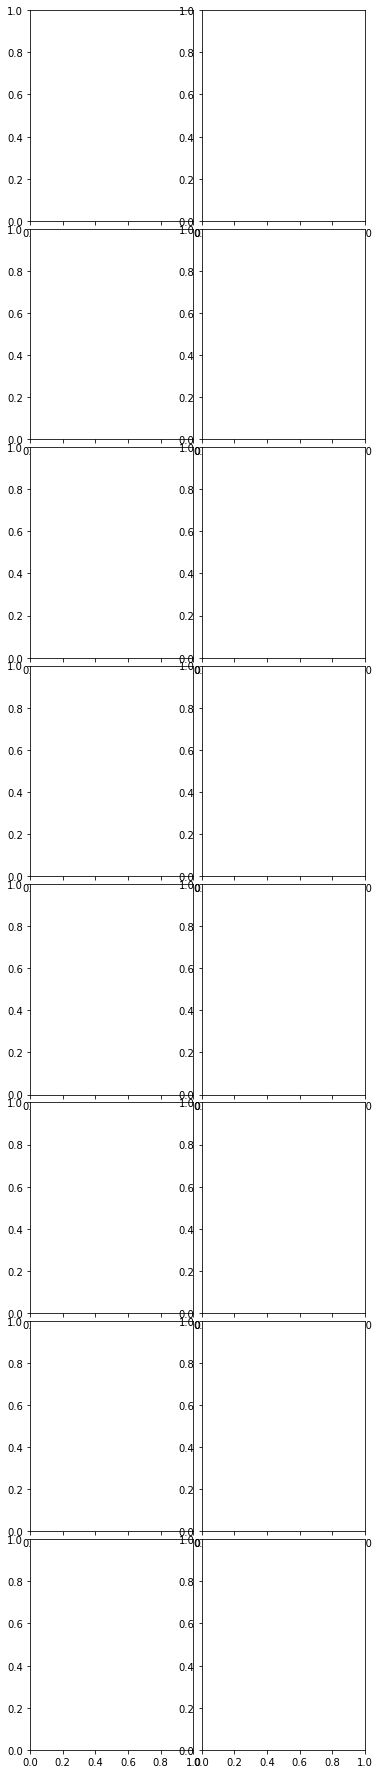

In [20]:
n_cols = 2
height = len(final_sampleorder)*4*n_samples/n_cols
width = n_cols*3

figure, axes = plt.subplots(int(n_samples/n_cols), n_cols)
    
figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05/(4/3))

In [57]:
for subkey in order:
    print(subkey)
    print(f'\t{[int(order.index(subkey)/2%8), order.index(subkey)%2]}')

Harvard_1
	[0, 0]
Harvard_2
	[0, 1]
Stanford_1
	[1, 0]
Stanford_2
	[1, 1]
VIB_1
	[2, 0]
VIB_2
	[2, 1]
CNAG_1
	[3, 0]
CNAG_2
	[3, 1]
Broad_1
	[4, 0]
Broad_2
	[4, 1]
Sanger_1
	[5, 0]
Sanger_2
	[5, 1]
VIB_Hydrop_1
	[6, 0]
VIB_Hydrop_2
	[6, 1]
OHSU
	[7, 0]
merged
	[7, 1]


In [59]:
color_max = max(max_dict.values())
with open(f'heatmap_mats/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl', 'rb') as f:
    max_dict = pickle.load(f)

for key in final_sampleorder:
    with open(coveragemats_dict[key], 'rb') as f:
        print(f'loading {key}...')
        mat_dict = pickle.load(f)
    for subkey in order:
        g = sns.heatmap(mat_dict[subkey][0:top_n], cmap="viridis", cbar=False, ax=axes[int(order.index(subkey)/2%8), order.index(subkey)%2], vmax=color_max, xticklabels=False, yticklabels=False)
        axes[int(order.index(subkey)/2%8), order.index(subkey)%2].set_title(alias_dict[subkey], color=color_dict[subkey])
        print(f'\tplotted {subkey} at row {int(order.index(subkey)/2%8)}, col {order.index(subkey)%2}, title {alias_dict[subkey]}')
        
    print(f'{key} processed!')
figure.tight_layout()

loading merged...
	plotted Harvard_1 at row 0, col 0, title BioRad ATAC 1
	plotted Harvard_2 at row 0, col 1, title BioRad ATAC 2
	plotted Stanford_1 at row 1, col 0, title 10x ATAC A1
	plotted Stanford_2 at row 1, col 1, title 10x ATAC A2
	plotted VIB_1 at row 2, col 0, title 10x ATAC B1
	plotted VIB_2 at row 2, col 1, title 10x ATAC B2
	plotted CNAG_1 at row 3, col 0, title 10x ATAC C1
	plotted CNAG_2 at row 3, col 1, title 10x ATAC C2
	plotted Broad_1 at row 4, col 0, title 10x mtATAC 1
	plotted Broad_2 at row 4, col 1, title 10x mtATAC 2
	plotted Sanger_1 at row 5, col 0, title 10x Multiome 1
	plotted Sanger_2 at row 5, col 1, title 10x Multiome 2
	plotted VIB_Hydrop_1 at row 6, col 0, title Hydrop ATAC 1
	plotted VIB_Hydrop_2 at row 6, col 1, title Hydrop ATAC 2
	plotted OHSU at row 7, col 0, title s3 ATAC
	plotted merged at row 7, col 1, title Merged
merged processed!


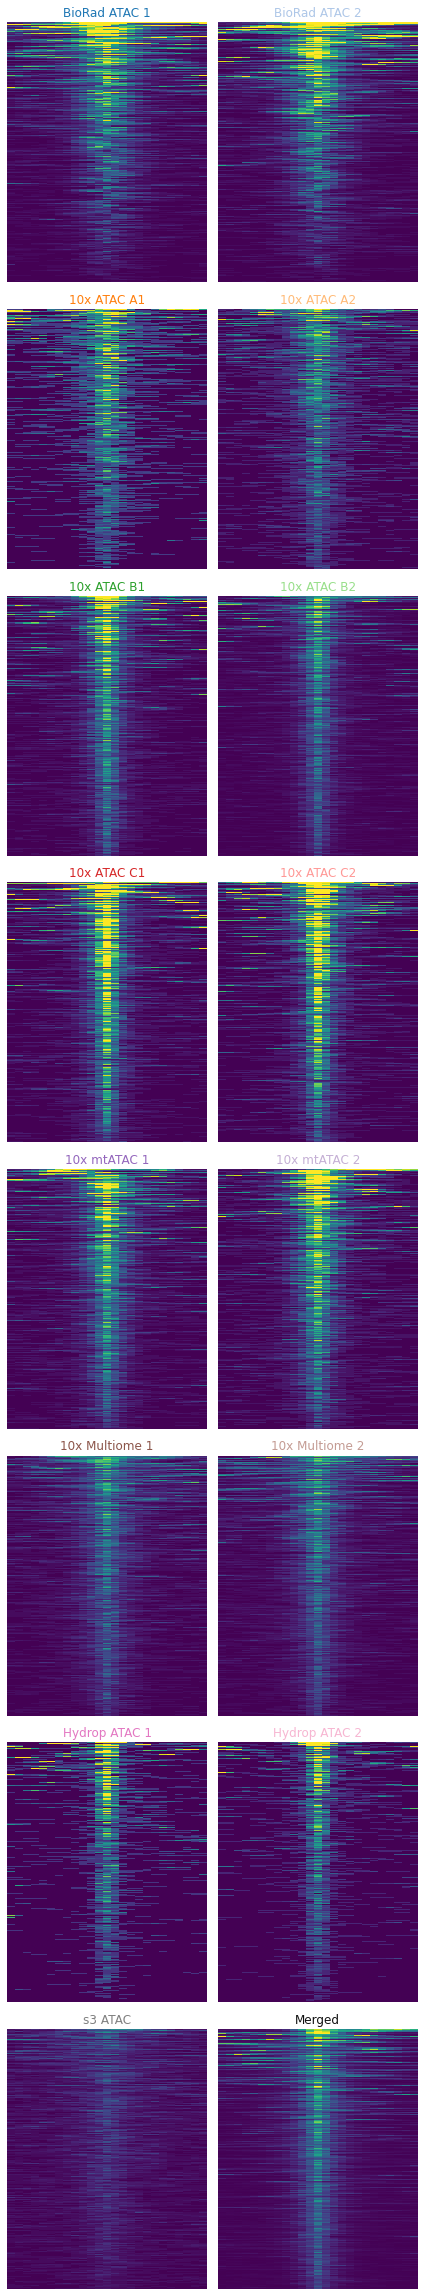

In [60]:
figure

Save the figure. A DPI of 50 is more than good enough.

In [61]:
dpi = 200
figure.savefig(
    f'plts_pub/merged_DARs_binsize{str(binsize)}_max_dict_refined_top_{str(top_n)}_logfcorder_{str(dpi)}_dpi.tiff', dpi=dpi, facecolor='white', bbox_inches='tight')
figure.savefig(
    f'plts_pub/merged_DARs_binsize{str(binsize)}_max_dict_refined_top_{str(top_n)}_logfcorder_{str(dpi)}_dpi.png', dpi=dpi, facecolor='white', bbox_inches='tight')

# make big figure, binsize 20

In [62]:
top_n = 2000

In [63]:
binsize = 20
filenames = sorted(glob.glob('heatmap_mats/*'+str(binsize)+'_coveragemats_refined_logfcorder.pkl'))
samples = [item.replace('_DARs_binsize'+str(binsize)+'_coveragemats_refined_logfcorder.pkl', "") for item in filenames]
samples = [item.replace("heatmap_mats/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'Broad_1': 'heatmap_mats/Broad_1_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Broad_2': 'heatmap_mats/Broad_2_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CNAG_1': 'heatmap_mats/CNAG_1_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CNAG_2': 'heatmap_mats/CNAG_2_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Harvard_1': 'heatmap_mats/Harvard_1_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Harvard_2': 'heatmap_mats/Harvard_2_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'OHSU': 'heatmap_mats/OHSU_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Sanger_1': 'heatmap_mats/Sanger_1_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Sanger_2': 'heatmap_mats/Sanger_2_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Stanford_1': 'heatmap_mats/Stanford_1_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Stanford_2': 'heatmap_mats/Stanford_2_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'VIB_1': 'heatmap_mats/VIB_1

In [64]:
with open(f'heatmap_mats/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl', 'rb') as f:
    max_dict = pickle.load(f)

In [65]:
mat_dict = {}
df_merged = pd.DataFrame()
for key in final_sampleorder:
    with open(coveragemats_dict[key], 'rb') as f:
        print(f'loading {key}...')
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)

maximum = np.quantile(df_merged, 0.99)
print(maximum)

loading merged...
7.316644377708446


# plot

In [66]:
final_sampleorder = ['merged']
n_samples = 16

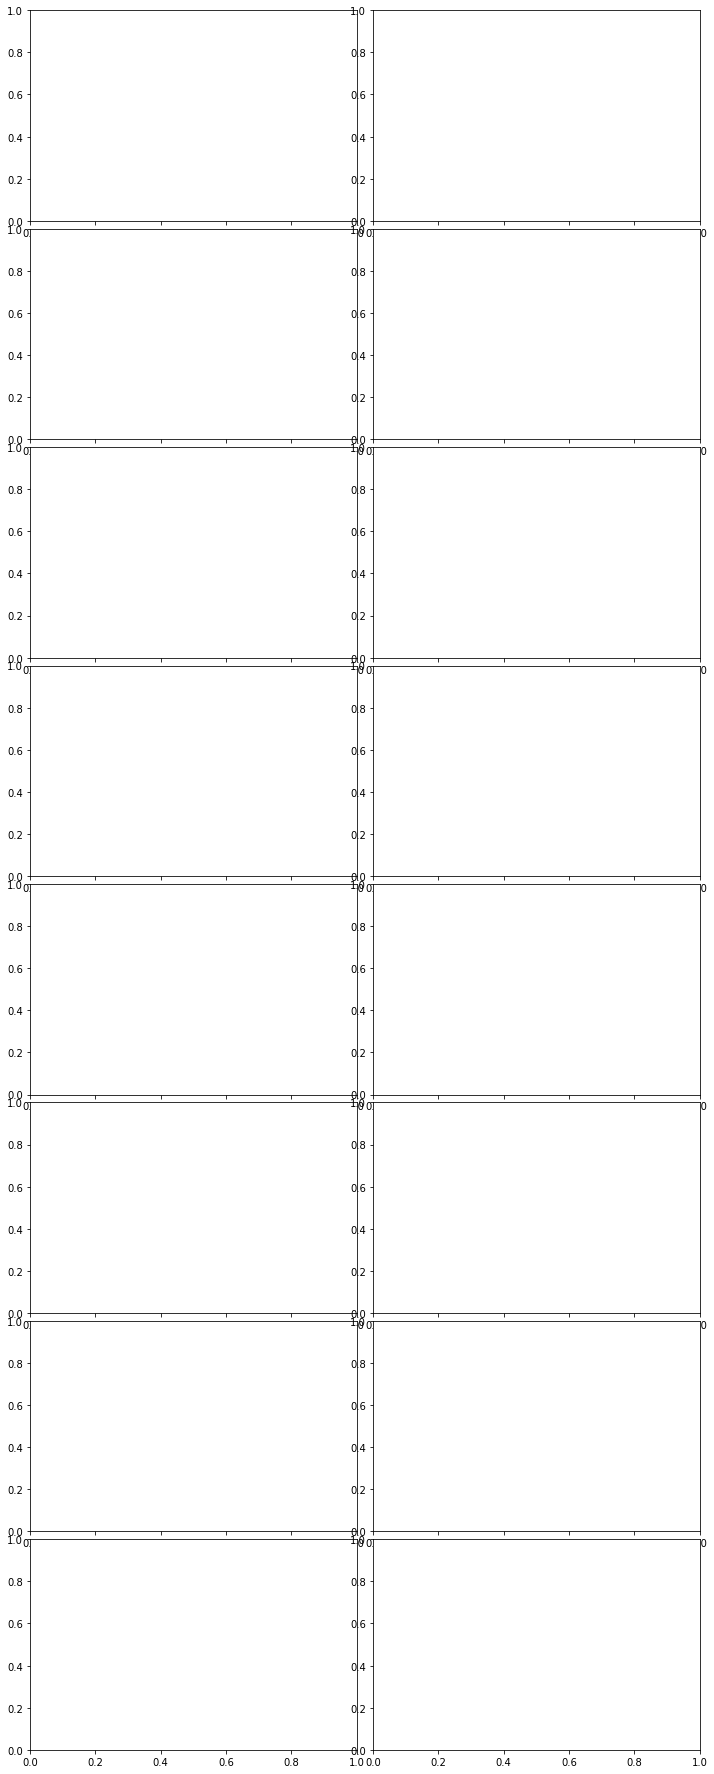

In [80]:
n_cols = 2
height = len(final_sampleorder)*4*n_samples/n_cols
width = n_cols*6

figure, axes = plt.subplots(int(n_samples/n_cols), n_cols)
    
figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05/(4/3))

In [81]:
for subkey in order:
    print(subkey)
    print(f'\t{[int(order.index(subkey)/2%8), order.index(subkey)%2]}')

Harvard_1
	[0, 0]
Harvard_2
	[0, 1]
Stanford_1
	[1, 0]
Stanford_2
	[1, 1]
VIB_1
	[2, 0]
VIB_2
	[2, 1]
CNAG_1
	[3, 0]
CNAG_2
	[3, 1]
Broad_1
	[4, 0]
Broad_2
	[4, 1]
Sanger_1
	[5, 0]
Sanger_2
	[5, 1]
VIB_Hydrop_1
	[6, 0]
VIB_Hydrop_2
	[6, 1]
OHSU
	[7, 0]
merged
	[7, 1]


In [91]:
color_max = max(max_dict.values())
with open(f'heatmap_mats/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl', 'rb') as f:
    max_dict = pickle.load(f)

for key in final_sampleorder:
    with open(coveragemats_dict[key], 'rb') as f:
        print(f'loading {key}...')
        mat_dict = pickle.load(f)
    for subkey in order:
        g = sns.heatmap(mat_dict[subkey][0:top_n], cmap="viridis", cbar=False, ax=axes[int(order.index(subkey)/2%8), order.index(subkey)%2], vmax=color_max, xticklabels=False, yticklabels=False)
        axes[int(order.index(subkey)/2%8), order.index(subkey)%2].set_title(alias_dict[subkey], color=color_dict[subkey], fontsize=24)
        print(f'\tplotted {subkey} at row {int(order.index(subkey)/2%8)}, col {order.index(subkey)%2}, title {alias_dict[subkey]}')
        
    print(f'{key} processed!')
figure.tight_layout()

loading merged...
	plotted Harvard_1 at row 0, col 0, title BioRad ATAC 1
	plotted Harvard_2 at row 0, col 1, title BioRad ATAC 2
	plotted Stanford_1 at row 1, col 0, title 10x ATAC A1
	plotted Stanford_2 at row 1, col 1, title 10x ATAC A2
	plotted VIB_1 at row 2, col 0, title 10x ATAC B1
	plotted VIB_2 at row 2, col 1, title 10x ATAC B2
	plotted CNAG_1 at row 3, col 0, title 10x ATAC C1
	plotted CNAG_2 at row 3, col 1, title 10x ATAC C2
	plotted Broad_1 at row 4, col 0, title 10x mtATAC 1
	plotted Broad_2 at row 4, col 1, title 10x mtATAC 2
	plotted Sanger_1 at row 5, col 0, title 10x Multiome 1
	plotted Sanger_2 at row 5, col 1, title 10x Multiome 2
	plotted VIB_Hydrop_1 at row 6, col 0, title Hydrop ATAC 1
	plotted VIB_Hydrop_2 at row 6, col 1, title Hydrop ATAC 2
	plotted OHSU at row 7, col 0, title s3 ATAC
	plotted merged at row 7, col 1, title Merged
merged processed!


In [95]:
for key in final_sampleorder:
    for subkey in order:
        axes[int(order.index(subkey)/2%8), order.index(subkey)%2].set_title(alias_dict[subkey], color='w', fontsize=24)
        print(f'\tplotted {subkey} at row {int(order.index(subkey)/2%8)}, col {order.index(subkey)%2}, title {alias_dict[subkey]}')

	plotted Harvard_1 at row 0, col 0, title BioRad ATAC 1
	plotted Harvard_2 at row 0, col 1, title BioRad ATAC 2
	plotted Stanford_1 at row 1, col 0, title 10x ATAC A1
	plotted Stanford_2 at row 1, col 1, title 10x ATAC A2
	plotted VIB_1 at row 2, col 0, title 10x ATAC B1
	plotted VIB_2 at row 2, col 1, title 10x ATAC B2
	plotted CNAG_1 at row 3, col 0, title 10x ATAC C1
	plotted CNAG_2 at row 3, col 1, title 10x ATAC C2
	plotted Broad_1 at row 4, col 0, title 10x mtATAC 1
	plotted Broad_2 at row 4, col 1, title 10x mtATAC 2
	plotted Sanger_1 at row 5, col 0, title 10x Multiome 1
	plotted Sanger_2 at row 5, col 1, title 10x Multiome 2
	plotted VIB_Hydrop_1 at row 6, col 0, title Hydrop ATAC 1
	plotted VIB_Hydrop_2 at row 6, col 1, title Hydrop ATAC 2
	plotted OHSU at row 7, col 0, title s3 ATAC
	plotted merged at row 7, col 1, title Merged


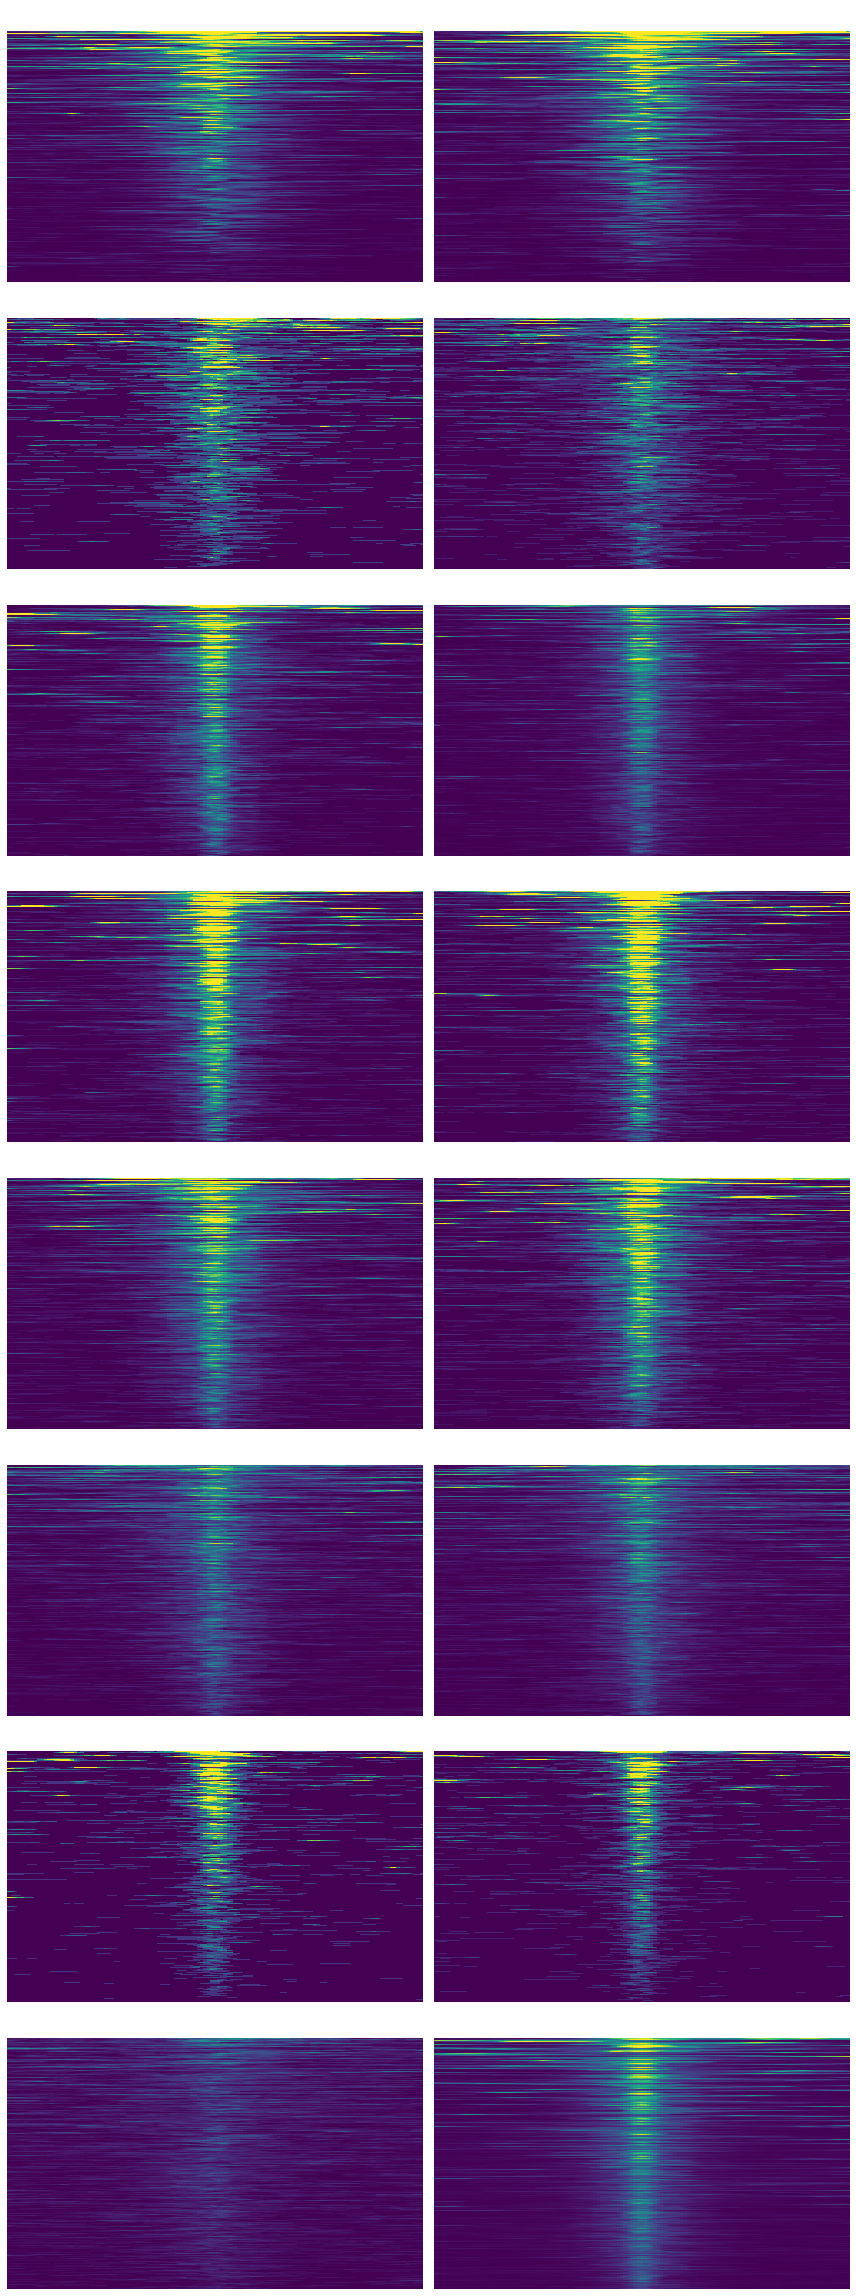

In [96]:
figure

Save the figure. A DPI of 50 is more than good enough.

In [97]:
dpi = 200
figure.savefig(
    f'plts_pub/merged_DARs_binsize{str(binsize)}_max_dict_refined_top_{str(top_n)}_logfcorder_{str(dpi)}_dpi.tiff', dpi=dpi, facecolor='white', bbox_inches='tight')
figure.savefig(
    f'plts_pub/merged_DARs_binsize{str(binsize)}_max_dict_refined_top_{str(top_n)}_logfcorder_{str(dpi)}_dpi.png', dpi=dpi, facecolor='white', bbox_inches='tight')